# Model Training

This notebook contains cleaning the text ingested in the `Data Ingestion` notebook and create supervised machine learning models to understand customer sentiment and evaluate them using a test set. 

### Contents:

1. [Data Exploration](#Data-Exploration)
2. [Text Cleaning](#Cleaning-Text)
3. [Logistic Regression](#Logistic-Regression)
4. [Multinomial Naive Bayes](#Multinomial-Naive-Bayes)


## Importing Libraries

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model  import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import GridSearchCV


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, f1_score

from collections import Counter

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from wordcloud import WordCloud

import warnings
warnings.filterwarnings("ignore")

## Importing Dataset

In [2]:
df = pd.read_csv('artifacts/data/Amazon_Reviews_Merged.csv')
df.head()

,overall,reviewText,category
0,4,Times have finally changed for Mac users when ...,Software
1,5,I am very surprised to really like this produc...,Luxury_Beauty
2,5,Very cute! And it's already wrapped! I just ad...,Gift_Cards
3,5,"I have been using ""Udderly Smooth"" (unscented)...",Luxury_Beauty
4,2,I found this shampoo difficult to lather. I re...,Luxury_Beauty


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63110 entries, 0 to 63109
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   overall     63110 non-null  int64 
 1   reviewText  63110 non-null  object
 2   category    63110 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB


In [4]:
print(f'Shape of the dataset: {df.shape}')

Shape of the dataset: (63110, 3)


# Data Exploration

In [5]:
df.isna().sum()

overall       0
reviewText    0
category      0
dtype: int64

In [6]:
df.duplicated().sum()

22343

**Since, the data has a lot of duplicate values. We will drop them.**

In [7]:
df=df.drop_duplicates()
df.duplicated().sum()

0

### Plotting Value Counts of Sentiments

In [8]:
review_counts = df['overall'].value_counts()
review_counts

overall
5    21967
4     9840
3     4900
1     2126
2     1934
Name: count, dtype: int64

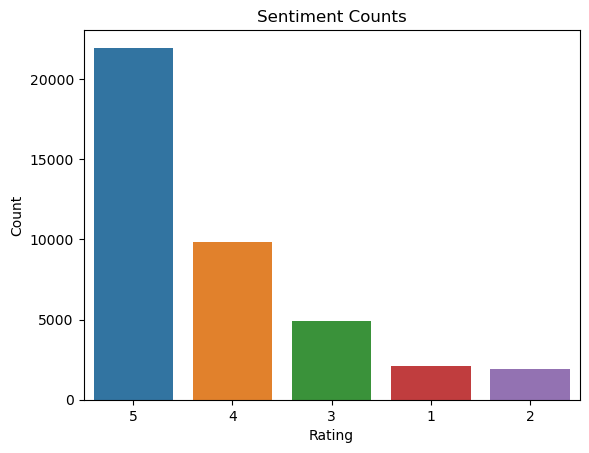

In [9]:
x_ = [str(i) for i in review_counts.index]
y_ = review_counts.values

sns.barplot(x=x_, y=y_)
plt.title('Sentiment Counts')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

# Cleaning Text

In [10]:
def clean_text(texts):
    cleaned_texts = []
    stopwords_eng = stopwords.words('english')
    count = 0
    for text in texts:
        #removing hyperlinks
        text_ = re.sub(r'https?://[^\s\n\r]+', ' ', text)
        #removing punctuations and digits, only taking words
        text_ = re.sub('[^a-zA-z]', ' ', text_)
        text_ = re.sub(r'[\W_]+', ' ', text_)
        text_ = text_.lower()
        words = nltk.word_tokenize(text_)
        words = [word for word in words if word not in stopwords_eng]
        cleaned_texts.append(' '.join(words))
        count += 1
        if count % 5000 == 0:
            print(f'Cleaned {count} text')
    print(f'Cleaned {count} text')
    print('Completed cleaning text')
    return np.array(cleaned_texts)

In [11]:
texts = df['reviewText'].copy()
texts.head()

0    Times have finally changed for Mac users when ...
1    I am very surprised to really like this produc...
2    Very cute! And it's already wrapped! I just ad...
3    I have been using "Udderly Smooth" (unscented)...
4    I found this shampoo difficult to lather. I re...
Name: reviewText, dtype: object

In [12]:
cleaned_texts = clean_text(texts)

Cleaned 5000 text
Cleaned 10000 text
Cleaned 15000 text
Cleaned 20000 text
Cleaned 25000 text
Cleaned 30000 text
Cleaned 35000 text
Cleaned 40000 text
Cleaned 40767 text
Completed cleaning text


In [13]:
lemmatizer = WordNetLemmatizer()
def lemmatize_text(texts):
    lem_texts = []
    count = 0
    for text in texts:
        lem_words = [lemmatizer.lemmatize(word) for word in nltk.word_tokenize(text)]
        lem_text = ' '.join(lem_words)
        lem_texts.append(lem_text)
        count += 1
        if count % 5000 == 0:
            print(f'Lemmatized {count} text')
    print(f'Lemmatized {count} text')
    return np.array(lem_texts)

In [14]:
lem_texts = lemmatize_text(cleaned_texts)

Lemmatized 5000 text
Lemmatized 10000 text
Lemmatized 15000 text
Lemmatized 20000 text
Lemmatized 25000 text
Lemmatized 30000 text
Lemmatized 35000 text
Lemmatized 40000 text
Lemmatized 40767 text


In [15]:
text = ' '.join(lem_texts)
chars = set(list(text))
print(chars)

{'z', 'm', 'f', 'x', 'q', ' ', 'w', 'y', 'g', 'c', 'i', 'v', 'r', 'o', 'p', 'a', 's', 'l', 'u', 'h', 'j', 't', 'b', 'n', 'e', 'd', 'k'}


In [16]:
print(f'Number of Words: {len(set(text.split()))}')

Number of Words: 36136


In [17]:
word_counts = Counter(text.split())
top_words = word_counts.most_common(10)
for word, count in top_words:
    print(f' {word} : {count}')

 product : 29544
 like : 22707
 skin : 22606
 use : 21243
 one : 16121
 time : 12628
 work : 12386
 get : 12186
 good : 12158
 really : 11850


### Plotting a word cloud

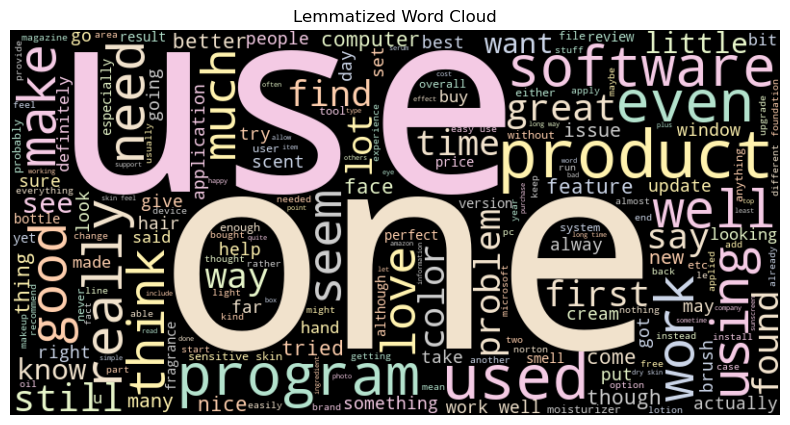

In [18]:
wordcloud = WordCloud(width=800, height=400, background_color="black", colormap='Pastel2').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Lemmatized Word Cloud")
plt.show()

## Spliting into train and test sets

In [19]:
print(f'Length of input: {len(lem_texts)}')
print(f'Length of output: {len(df["overall"])}')

Length of input: 40767
Length of output: 40767


**So we have 40767 samples. Splitting in test and train datasets** 

In [20]:
X = np.copy(lem_texts)
y = df['overall'].copy()
y = y - 1
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=2000)

In [21]:
print('Train Sample Size: ', X_train.shape, y_train.shape)
print('Test Sample Size: ', X_test.shape, y_test.shape)

Train Sample Size:  (38767,) (38767,)
Test Sample Size:  (2000,) (2000,)


## Vectorizing Text

In [22]:
tfidf_vec = TfidfVectorizer(max_features = 2000)
tfidf_vec.fit(X_train)

TfidfVectorizer(max_features=2000)

In [23]:
X_train_vec = tfidf_vec.transform(X_train).toarray()
print(f'Length of Vectorized Text Matrix : {X_train_vec.shape}')

Length of Vectorized Text Matrix : (38767, 2000)


### Scaling

In [24]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_vec)

# Logistic Regression 

In [33]:
logistic = LogisticRegression()

## Grid Searching Best Params

In [34]:
param_grid = {
    'max_iter': [100, 200],
    'multi_class': ['ovr', 'multinomial'],
    'C': [0.001, 0.01]  
}

grid_search = GridSearchCV(logistic, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01], 'max_iter': [100, 200],
                         'multi_class': ['ovr', 'multinomial']},
             scoring='accuracy')

In [35]:
print("Best Parameters: ", grid_search.best_params_)
print("Best Accuracy: ", grid_search.best_score_)

Best Parameters:  {'C': 0.001, 'max_iter': 100, 'multi_class': 'multinomial'}
Best Accuracy:  0.6117831728861245


In [36]:
best_logistic_model = grid_search.best_estimator_

### Evaluating

In [37]:
X_test_vec = tfidf_vec.transform(X_test).toarray()
X_test_scaled = scaler.transform(X_test_vec)

In [38]:
test_score = best_logistic_model.score(X_test_scaled, y_test)
print(f'Test Score: {test_score}')

Test Score: 0.6195


### Confusion Matrix and F1 Score

In [39]:
y_pred = best_logistic_model.predict(X_test_scaled)
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))

Confusion Matrix:
[[ 43   8  14   3  31]
 [ 18   8  11  20  48]
 [  7   8  55  73  80]
 [  3   3  44 183 251]
 [  4   3  15 117 950]]


In [41]:
f1_scores = f1_score(y_test, y_pred, average=None)

for i, fi in enumerate(f1_scores):
    print(f'F1 score of Class {i} = {fi}')

print('-'*10)

avg_f1_score = f1_score(y_test, y_pred, average='weighted')
print(f'Average F1 score = {avg_f1_score}')

F1 score of Class 0 = 0.4942528735632184
F1 score of Class 1 = 0.11851851851851852
F1 score of Class 2 = 0.30386740331491713
F1 score of Class 3 = 0.4159090909090909
F1 score of Class 4 = 0.7758268681094324
----------
Average F1 score = 0.5876566846188007


# Multinomial Naive Bayes

In [25]:
multiNB  = MultinomialNB()

## Grid Seacrhing Best Parameters

In [27]:
param_grid = {
    'alpha': [0.1, 0.5, 1.0, 1.5],
    'fit_prior': [True, False]
}

grid_search = GridSearchCV(multiNB, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_vec, y_train)

GridSearchCV(cv=5, estimator=MultinomialNB(),
             param_grid={'alpha': [0.1, 0.5, 1.0, 1.5],
                         'fit_prior': [True, False]},
             scoring='accuracy')

In [28]:
print("Best Parameters: ", grid_search.best_params_)
print("Best Accuracy: ", grid_search.best_score_)

Best Parameters:  {'alpha': 0.1, 'fit_prior': True}
Best Accuracy:  0.5657130834824404


In [31]:
best_multiNB_model = grid_search.best_estimator_
test_score = best_multiNB_model.score(X_test_vec, y_test)
print(f'Test Score: {test_score}')

Test Score: 0.564


### Confusion Matrix and F1 Score

In [42]:
y_pred = best_multiNB_model.predict(X_test_vec)
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))

Confusion Matrix:
[[ 45   0   1   2  51]
 [ 15   0   1  19  70]
 [ 21   0   7  54 141]
 [ 33   0   2  82 367]
 [ 42   0   0  53 994]]


In [43]:
f1_scores = f1_score(y_test, y_pred, average=None)

for i, fi in enumerate(f1_scores):
    print(f'F1 score of Class {i} = {fi}')

print('-'*10)

avg_f1_score = f1_score(y_test, y_pred, average='weighted')
print(f'Average F1 score = {avg_f1_score}')

F1 score of Class 0 = 0.3529411764705882
F1 score of Class 1 = 0.0
F1 score of Class 2 = 0.05982905982905984
F1 score of Class 3 = 0.23631123919308358
F1 score of Class 4 = 0.7330383480825958
----------
Average F1 score = 0.48046822882193396


# Conclusion

We can see in confusion matrices that most of samples are wrongly classified to class 3 (sentiment = 4) or class 4 (sentiment = 5) because of large number of samples from that class. Also, the model does a bad job at predicting samples from class 1 (sentiment = 2) and class 2 (sentiment = 3). We can fix this by undersampling which will be explored in another Jupyter Notebook.